In [1]:
import models
import numpy as np
import pandas as pd
from numpy import sqrt, exp, pi, power, tanh, vectorize
from scipy.integrate import odeint
from scipy.interpolate import make_interp_spline, interp1d
import matplotlib.pyplot as plt

In [2]:
folder = ''

In [3]:
### Read input file
input_file = pd.read_csv(folder+'input_irradiance_mel.csv', sep=";", decimal=",")
minE = min(min(input_file.irradiance_mel),0.036)
maxE = max(max(input_file.irradiance_mel), 0.22)

In [4]:
### Create steps from input irradiance
input_file['hour'] = round(input_file.hours,0)
input_step = input_file[['irradiance_mel','hour']].groupby('hour').mean()
input_step.reset_index(inplace=True)

In [5]:
### Smooth input irradiance with second degree polynomial
x = input_file.hours
a = np.polyfit(x, input_file.irradiance_mel, 2)
input_file['irradiance_mel_smooth'] = a[0] * power(x,2) + a[1] * x + a[2]

In [6]:
output_file = pd.read_csv(folder+"output.csv", sep=";", decimal=",")
n = output_file.shape[0]
output_file['E_mel'] = output_file.I_mel*0.0013262 # convert to irradiance

In [7]:
### Find nearest point in vector
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Return irradiance at time t
def irradiance(t):
    t = t/3600
    t = t % 24
    if ((t < 8.0) or (t > 20.0)): 
        E_emel = 0.036 # from the scientist: 27 lux
    elif ((t < 9.0) or (t > 16.0)): 
        E_emel = 0.22 # from the scientist: 165 lux
    else:
        ### original data
        idx = find_nearest(input_file.hours, t)
        E_emel = input_file.irradiance_mel[idx]
        ### smoothed data (second order poly)
        # E_emel = input_file.irradiance_mel_smooth[idx]
        # idx = find_nearest(new_input.hour, t)
        ### aggregated by hour "step" data
        # E_emel = input_step.irradiance_mel[idx]
        # E_emel = 0.22 # step
    return E_emel

irradiance_v = vectorize(irradiance)

In [8]:
def forced_wake(t):
    # Testing with forced wake between t1 and t2
    #if ((t/3600 % 24) >= 6 and (t/3600 % 24) <= 24):
    #    F_w = 1
    #else:
    #    F_w = 0
    F_w = 0
    return F_w

forced_wake_v = vectorize(forced_wake)

In [9]:
#### Initial Conditions 
# [V_v, V_m, H, X, Y, P, Theta_L]

y0 = [1.5, -15.0, 13.0, 0.04, -1.28, 0.0, 0.0]

# y0 = [-4.497078351339751, -0.07000000000052416, 13.235369640119554, -0.07243371889456507, -0.7498943126792074, 0.998695292851908, 0.0]
# y0 = [-3.9849559306245554, -0.06999999999999991, 13.443772572885331, -0.8152711832774777, 0.10984121127149143, 0.08493027667594716, -0.03543102672658369]
# y0 = [2.902150366506143, -14.159798106868699, 13.299816271267845, -0.7966368638117368, 0.2637919920821084, 0.06249713611782928, -0.05188881098166024]
# y0 = [ 1.888050284627664, -10.000676037696763, 12.547896533553217, -1.0889180236787013, -0.2654388779780049, 0.06231185031284664, -0.05499507929393252]
# y0 = [ 1.745102761767178, -9.50905050894146, 12.40606970294775, -1.076264422103, -0.09355980932875388, 0.056699021756750685, -0.054995079291803216]

In [10]:
### Execute the ODE model
t = np.linspace(0,72*60*60,n)
(sol,temp) = odeint(models.model, y0, t, args = (irradiance, forced_wake, minE, maxE, '2020',), full_output = True)

### Store results
V_v = sol[:, 0]
V_m = sol[:, 1]
H = sol[:, 2]
X = sol[:, 3]
Y = sol[:, 4]
P = sol[:, 5]
Theta_L = sol[:, 6]
t_hours = t/3600

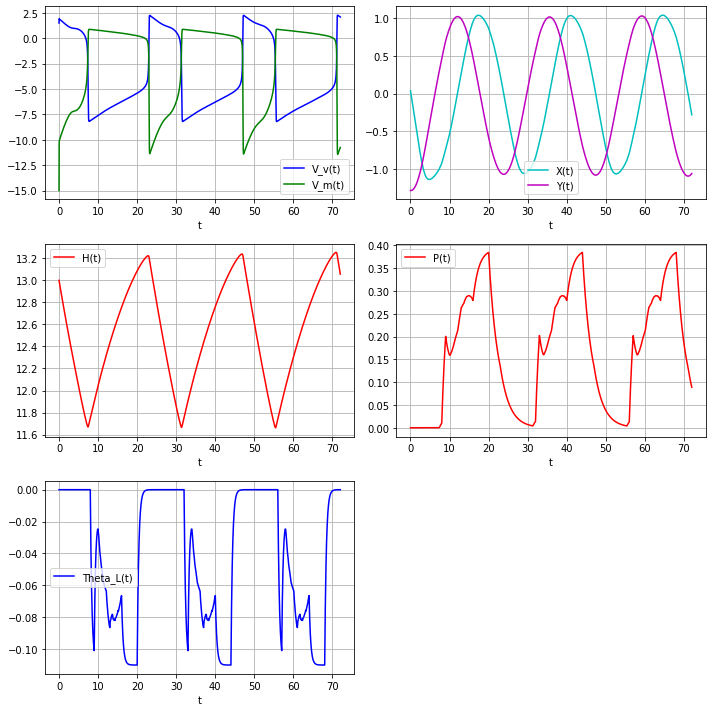

In [11]:
### Plot ODEs
plt.figure(figsize=(10, 10))

plt.subplot(3,2,1)
plt.plot(t_hours, V_v, 'b', label='V_v(t)')
plt.plot(t_hours, V_m, 'g', label='V_m(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(t_hours, X, 'c', label='X(t)')
plt.plot(t_hours, Y, 'm', label='Y(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(t_hours, H, 'r', label='H(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(t_hours, P, 'r', label='P(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(t_hours, Theta_L, 'b', label='Theta_L(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
### Compute all the internal functions
IE    = irradiance_v(t)
S     = models.state_v(V_m) 
alpha = models.photoreceptor_conversion_rate_v(IE, S, '2020')
Q_m   = models.mean_population_firing_rate_v(V_m)
Q_v   = models.mean_population_firing_rate_v(V_v)
C     = models.circadian_drive_v(X,Y)
D_v   = models.total_sleep_drive_v(H,C)
D_n   = models.nonphotic_drive_v(X, S)
D_p   = models.photic_drive_v(X, Y, P, alpha)
F_w   = forced_wake_v(t)
W     = models.wake_effort_v(Q_v, F_w)
#Sigmoid = ( models.sigmoid_v(IE) - models.sigmoid_v(0) ) / ( models.sigmoid_v(0.8) - models.sigmoid_v(0) )
Sigmoid = ( models.sigmoid_v(IE) - models.sigmoid_v(minE) ) / ( models.sigmoid_v(maxE) - models.sigmoid_v(minE) )

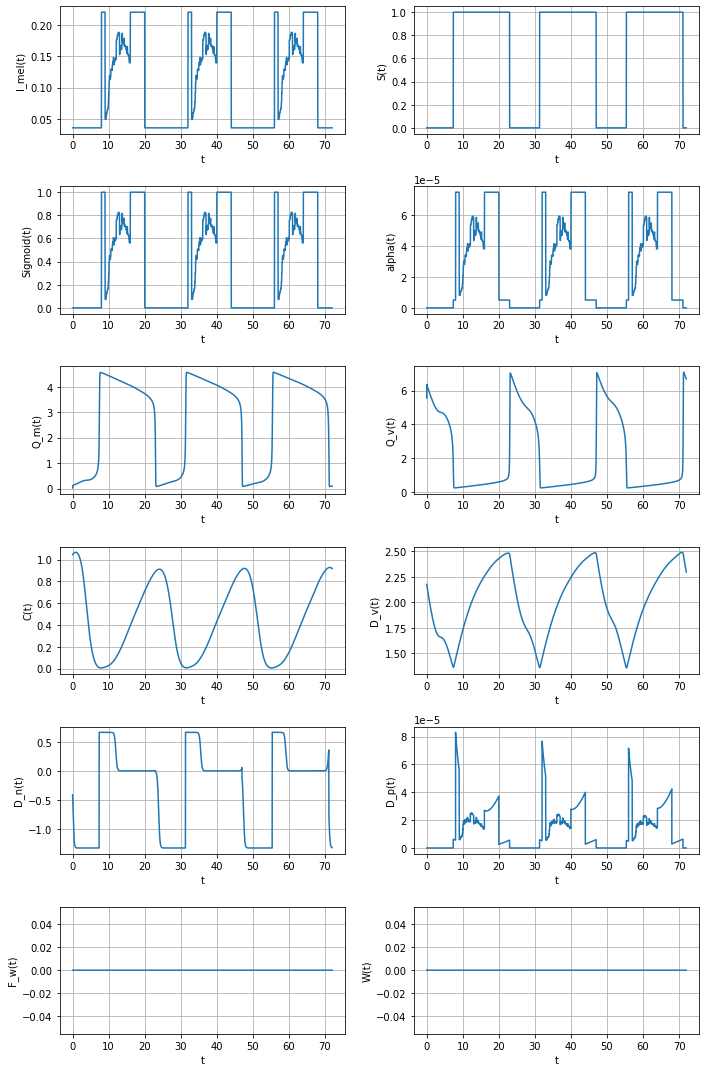

In [13]:
### Plot internal variables
plt.figure(figsize=(10, 15))

plt.subplot(6,2,1)
plt.plot(t_hours, IE)
plt.xlabel('t')
plt.ylabel('I_mel(t)')
plt.grid(True)

plt.subplot(6,2,2)
plt.plot(t_hours, S)
plt.xlabel('t')
plt.ylabel('S(t)')
plt.grid(True)

plt.subplot(6,2,3)
plt.plot(t_hours, Sigmoid)
plt.xlabel('t')
plt.ylabel('Sigmoid(t)')
plt.grid(True)

plt.subplot(6,2,4)
plt.plot(t_hours, alpha)
plt.xlabel('t')
plt.ylabel('alpha(t)')
plt.grid(True)

plt.subplot(6,2,5)
plt.plot(t_hours, Q_m)
plt.xlabel('t')
plt.ylabel('Q_m(t)')
plt.grid(True)

plt.subplot(6,2,6)
plt.plot(t_hours, Q_v)
plt.xlabel('t')
plt.ylabel('Q_v(t)')
plt.grid(True)

plt.subplot(6,2,7)
plt.plot(t_hours, C)
plt.xlabel('t')
plt.ylabel('C(t)')
plt.grid(True)

plt.subplot(6,2,8)
plt.plot(t_hours, D_v)
plt.xlabel('t')
plt.ylabel('D_v(t)')
plt.grid(True)

plt.subplot(6,2,9)
plt.plot(t_hours, D_n)
plt.xlabel('t')
plt.ylabel('D_n(t)')
plt.grid(True)

plt.subplot(6,2,10)
plt.plot(t_hours, D_p)
plt.xlabel('t')
plt.ylabel('D_p(t)')
plt.grid(True)

plt.subplot(6,2,11)
plt.plot(t_hours, F_w)
plt.xlabel('t')
plt.ylabel('F_w(t)')
plt.grid(True)

plt.subplot(6,2,12)
plt.plot(t_hours, W)
plt.xlabel('t')
plt.ylabel('W(t)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
AM = models.alertness_measure_v(C, H, Theta_L)

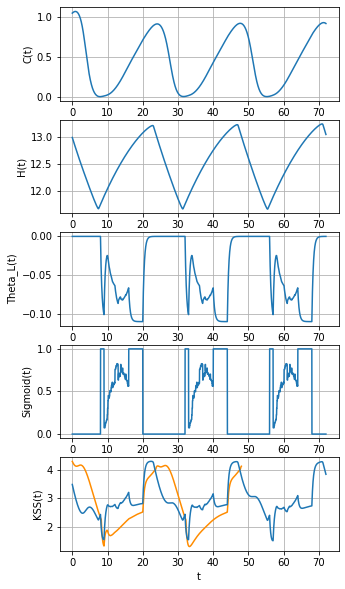

In [15]:
### Plot AM-related variables
plt.figure(figsize=(5, 10))

plt.subplot(5,1,1)
plt.plot(t_hours, C)
plt.xlabel('t')
plt.ylabel('C(t)')
plt.grid(True)

plt.subplot(5,1,2)
plt.plot(t_hours, H)
plt.xlabel('t')
plt.ylabel('H(t)')
plt.grid(True)

plt.subplot(5,1,3)
plt.plot(t_hours, Theta_L)
plt.xlabel('t')
plt.ylabel('Theta_L(t)')
plt.grid(True)

plt.subplot(5,1,4)
plt.plot(t_hours, Sigmoid)
plt.xlabel('t')
plt.ylabel('Sigmoid(t)')
plt.grid(True)

plt.subplot(5,1,5)
plt.plot(output_file.time, output_file.KSS, 'darkorange')
plt.plot(t_hours, AM)
plt.xlabel('t')
plt.ylabel('KSS(t)')
plt.grid(True)

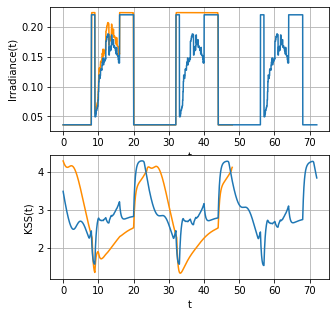

In [16]:
### Plot AM and Irradiance
plt.figure(figsize=(5, 5))

plt.subplot(2,1,1)
plt.plot(output_file.time, output_file.E_mel, 'darkorange')
plt.plot(t_hours, IE)
plt.xlabel('t')
plt.ylabel('Irradiance(t)')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(output_file.time, output_file.KSS, 'darkorange')
plt.plot(t_hours, AM)
plt.xlabel('t')
plt.ylabel('KSS(t)')
plt.grid(True)

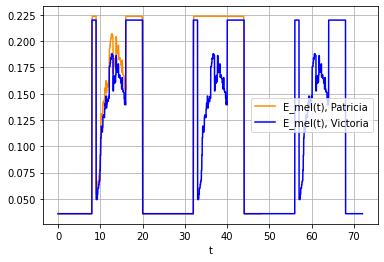

In [17]:
plt.plot(output_file.time, output_file.E_mel, 'darkorange', label='E_mel(t), Patricia')
plt.plot(t_hours, irradiance_v(t), 'b', label='E_mel(t), Victoria')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

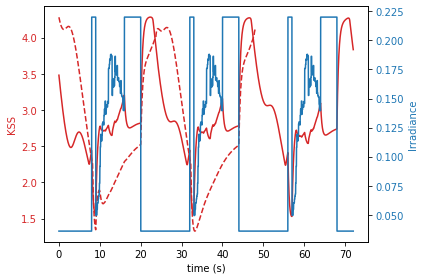

In [18]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('KSS', color=color)
ax1.plot(t_hours, AM, color=color)
ax1.plot(output_file.time, output_file.KSS, color=color, linestyle='dashed')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Irradiance', color=color)  # we already handled the x-label with ax1
ax2.plot(t_hours, irradiance_v(t), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [19]:
# find some initial conditions
idx = find_nearest(H, 13.3)
print("[ {}, {}, {}, {}, {}, {}, {}]".format(V_v[idx],V_m[idx],H[idx],X[idx],Y[idx],P[idx],Theta_L[idx]))


[ -3.669655548154942, -0.5318856164134155, 13.253275505205739, 0.03930491381883743, -1.0892905580443484, 0.13759927848894712, -7.650789461189779e-05]


In [20]:
# find some initial conditions
idx = find_nearest(t/3600, 48)
print("[ {}, {}, {}, {}, {}, {}, {}]".format(V_v[idx],V_m[idx],H[idx],X[idx],Y[idx],P[idx],Theta_L[idx]))

[ 2.050792232655501, -10.595399483006105, 13.024013878932044, -0.17123995190654875, -1.0640544357599868, 0.08788533688998176, -4.994014783102665e-06]
